In [0]:
from __future__ import print_function, division
import os
import torch
from torch.optim.optimizer import Optimizer
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

from torch.utils.tensorboard import SummaryWriter

import PIL
from PIL import Image

from google.colab import output

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

num_of_classes = 3

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3968 (delta 7), reused 33 (delta 5), pack-reused 3933
Receiving objects: 100% (3968/3968), 234.15 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (614/614), done.


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/batch-2/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [0]:
class custom_sgd_optimizer(Optimizer):
    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(custom_sgd_optimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(custom_sgd_optimizer, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group['lr'])

        return loss

In [61]:
network = Net(4096, 1500, 300, num_of_classes)
network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.0001, momentum=0.6)
criterion = nn.MSELoss().cuda()

print(network)

Net(
  (fc1): Linear(in_features=4096, out_features=1500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1500, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=3, bias=True)
)


In [0]:
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.2, momentum=0.2)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

In [30]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
network.to(dev)
criterion.to(dev)
dev

device(type='cuda')

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.1 GB
Cached:    0.2 GB


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: A_small


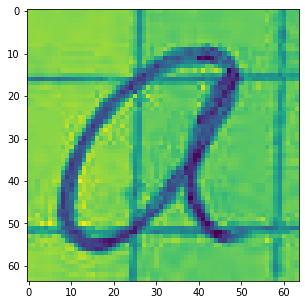

In [64]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [35]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [0]:
def name_to_int(data):

  switcher = {
      'A': 1,
      'B': 2,
      'C': 3,
      'A_small': 1,
      'P': 2,
      'u': 3
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [70]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []
  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_images_val = 0

    # TRAINING DATASET
    correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10

        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      images.cuda()
      labels.cuda()

      num_images_val = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].cuda().flatten().float())

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.repeat(-10, num_of_classes)
        real_value[labels[idx] - 1] = 10
        loss = criterion(outputs.cuda(), torch.Tensor(real_value).cuda()) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1],correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 100, 5)

Epoch: 0 Training loss: 6.24346852733288 Eval loss: 723.0546602131799 Correct: 96.15384615384616%
Epoch: 1 Training loss: 6.047294251562562 Eval loss: 735.1498495675623 Correct: 94.23076923076923%
Epoch: 2 Training loss: 5.846651293992181 Eval loss: 725.6348469285294 Correct: 96.15384615384616%
Epoch: 3 Training loss: 5.253299941483419 Eval loss: 744.4869621451944 Correct: 94.23076923076923%
Epoch: 4 Training loss: 5.671144122083206 Eval loss: 734.0816189367324 Correct: 94.23076923076923%
Epoch: 5 Training loss: 5.326593388308538 Eval loss: 726.8929497296922 Correct: 94.23076923076923%
Epoch: 6 Training loss: 5.079471291144728 Eval loss: 726.7881791461259 Correct: 94.23076923076923%
Epoch: 7 Training loss: 5.137126134723076 Eval loss: 727.9238590998575 Correct: 94.23076923076923%
Epoch: 8 Training loss: 4.621312374249101 Eval loss: 723.6222576471046 Correct: 94.23076923076923%
Epoch: 9 Training loss: 4.949761786439922 Eval loss: 722.120038528461 Correct: 94.23076923076923%
Epoch: 10 Tr

In [71]:
empty_image = io.imread('/content/Lithuanian_OCR/Data/white.jpg')
empty_image = rgb2gray(empty_image)
output = network(torch.Tensor(empty_image).cuda().flatten().float())
print(output)
print(get_max_from_tensor(output))
print(output[get_max_from_tensor(output) - 1])

prob_treshold = output[get_max_from_tensor(output) - 1].item()
print(prob_treshold)

tensor([-13.0260,   2.9800,  -3.5156], device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(2.9800, device='cuda:0', grad_fn=<SelectBackward>)
2.9800212383270264


In [72]:
lowest_prob = 100

for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].cuda().flatten().float())
    
    prob = output[get_max_from_tensor(output) - 1]
    if prob < lowest_prob:
      lowest_prob = prob

    if(get_max_from_tensor(output) == labels[i] and prob > prob_treshold):
      print("OK: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))
    elif(prob < prob_treshold):
      print("False: Detected empty image on {} with probability: {}".format(labels[i], prob))
    else:
      print("False: {} == {} Probability: {}".format(get_max_from_tensor(output), labels[i], prob))

print("Lowest Probability: {}".format(lowest_prob))

OK: 2 == 2 Probability: 8.452061653137207
OK: 2 == 2 Probability: 9.020755767822266
OK: 2 == 2 Probability: 11.350409507751465
OK: 3 == 3 Probability: 8.649484634399414
OK: 1 == 1 Probability: 7.202477931976318
OK: 3 == 3 Probability: 3.4014837741851807
OK: 3 == 3 Probability: 9.129841804504395
OK: 3 == 3 Probability: 6.421441078186035
OK: 3 == 3 Probability: 6.371933937072754
OK: 1 == 1 Probability: 6.030937194824219
OK: 2 == 2 Probability: 9.298827171325684
OK: 2 == 2 Probability: 10.614869117736816
OK: 2 == 2 Probability: 10.826493263244629
OK: 1 == 1 Probability: 9.290994644165039
OK: 1 == 1 Probability: 11.522485733032227
OK: 3 == 3 Probability: 3.2081894874572754
OK: 2 == 2 Probability: 11.298449516296387
OK: 1 == 1 Probability: 6.139896392822266
OK: 3 == 3 Probability: 7.125797271728516
OK: 1 == 1 Probability: 6.433068752288818
OK: 1 == 1 Probability: 3.687845468521118
OK: 2 == 2 Probability: 3.7099289894104004
OK: 2 == 2 Probability: 6.459685802459717
Lowest Probability: 3.2081

In [0]:
for opt in optimizer.param_groups:
  opt['lr'] = 0.00001

In [0]:
!cp '/content/results/model.pth' '/content/Lithuanian_OCR/Trained_model/model.pth'
!cp '/content/results/optimizer.pth' '/content/Lithuanian_OCR/Trained_model/optimizer.pth'